- **Date:** 2019-5-26
- **Author:** Zhanyuan Zhang
- **Purpose:** 
    - Inspects the structure of BagNet to help understand it
    - Visualizs the saliency maps and makes comparison between the saliency maps between correctly classified images and misclassified images

In [0]:
%load_ext autoreload
%autoreload 2

In [0]:
import os
from google.colab import drive
drive.mount('/content/gdrive')
os.chdir('/content/gdrive/My Drive/dl-security/') #Change the path to the directory that contains all code and data

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
!pip install https://github.com/bethgelab/foolbox/archive/master.zip

     | 6.1MB 4.4MB/s
  Stored in directory: /tmp/pip-ephem-wheel-cache-5qg9ongy/wheels/3d/cb/2b/54e486add16cbc5a86392b539df012f5a775faa609321caaf4
Successfully built foolbox


In [0]:
from bagnets.utils import plot_heatmap, generate_heatmap_pytorch
from bagnets.utils import pad_image, convert2channel_last, imagenet_preprocess, extract_patches, bagnet_predict, compare_heatmap
from foolbox.utils import samples
import bagnets.pytorch
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import numpy as np
import time
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
if use_cuda:
    print(torch.cuda.get_device_name(0))

Tesla T4


## Inspect the structure of BagNet33

In [0]:
# load pretrained model
pytorch_model = bagnets.pytorch.bagnet33(pretrained=True).to(device)
pytorch_model

BagNet(
  (conv1): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(256, eps=1e-05

In [0]:
from bagnets.pytorch import Bottleneck
import torch.nn as nn
import math
from torch.utils import model_zoo

model_urls = {
            'bagnet9': 'https://bitbucket.org/wielandbrendel/bag-of-feature-pretrained-models/raw/249e8fa82c0913623a807d9d35eeab9da7dcc2a8/bagnet8-34f4ccd2.pth.tar',
            'bagnet17': 'https://bitbucket.org/wielandbrendel/bag-of-feature-pretrained-models/raw/249e8fa82c0913623a807d9d35eeab9da7dcc2a8/bagnet16-105524de.pth.tar',
            'bagnet33': 'https://bitbucket.org/wielandbrendel/bag-of-feature-pretrained-models/raw/249e8fa82c0913623a807d9d35eeab9da7dcc2a8/bagnet32-2ddd53ed.pth.tar',
                            }

class BottleneckDebug(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, kernel_size=1):
        super(BottleneckDebug, self).__init__()
        # print('Creating bottleneck with kernel size {} and stride {} with padding {}'.format(kernel_size, stride, (kernel_size - 1) // 2))
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=kernel_size, stride=stride,
                               padding=0, bias=False) # changed padding from (kernel_size - 1) // 2
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x, **kwargs):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            print('Bottleneck: shape before downsampling {}'.format(x.shape))
            residual = self.downsample(x)
        
        if residual.size(-1) != out.size(-1):
            print('Bottleneck: shape after downsampling {}'.format(residual.shape))
            print('Bottleneck: shape of out {}'.format(out.shape))
            diff = residual.size(-1) - out.size(-1)
            residual = residual[:,:,:-diff,:-diff]
        
        out += residual
        out = self.relu(out)

        return out


class BagNetDebug(nn.Module):

    def __init__(self, block, layers, strides=[1, 2, 2, 2], kernel3=[0, 0, 0, 0], num_classes=1000, avg_pool=True):
        self.inplanes = 64
        super(BagNetDebug, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=1, stride=1, padding=0,
                               bias=False)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64, momentum=0.001)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 64, layers[0], stride=strides[0], kernel3=kernel3[0], prefix='layer1')
        self.layer2 = self._make_layer(block, 128, layers[1], stride=strides[1], kernel3=kernel3[1], prefix='layer2')
        self.layer3 = self._make_layer(block, 256, layers[2], stride=strides[2], kernel3=kernel3[2], prefix='layer3')
        self.layer4 = self._make_layer(block, 512, layers[3], stride=strides[3], kernel3=kernel3[3], prefix='layer4')
        #self.avgpool = nn.AvgPool2d(1, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        self.avg_pool = avg_pool
        self.block = block

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1, kernel3=0, prefix=''):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        kernel = 1 if kernel3 == 0 else 3
        layers.append(block(self.inplanes, planes, stride, downsample, kernel_size=kernel))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            kernel = 1 if kernel3 <= i else 3
            layers.append(block(self.inplanes, planes, kernel_size=kernel))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        print('BagNet: shape after conv1 {}\n'.format(x.shape))
        x = self.conv2(x)
        print('BagNet: shape after conv2 {}\n'.format(x.shape))
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        print('BagNet: shape after layer1 {}\n'.format(x.shape))
        x = self.layer2(x)
        print('BagNet: shape after layer2 {}\n'.format(x.shape))
        x = self.layer3(x)
        print('BagNet: shape after layer3 {}\n'.format(x.shape))
        x = self.layer4(x)
        print('BagNet: shape after layer4 {}\n'.format(x.shape))

        if self.avg_pool:
            print('BagNet: kernel size of AvgPool2d: {}'.format(x.size()[2]))
            x = nn.AvgPool2d(x.size()[2], stride=1)(x)
            x = x.view(x.size(0), -1)
            x = self.fc(x)
        else:
            x = x.permute(0,2,3,1)
            x = self.fc(x)

        return x

def bagnet33_debug(pretrained=False, strides=[2, 2, 2, 1], **kwargs):
    """Constructs a Bagnet-33 model (Debugging mode).
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = BagNetDebug(BottleneckDebug, [3, 4, 6, 3], strides=strides, kernel3=[1,1,1,1], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['bagnet33']))
    return model

In [0]:
bagnet33_db = bagnet33_debug(pretrained=True).to(device)

In [0]:
images, labels = samples(dataset='imagenet', index=1, batchsize=20, shape=(224, 224), data_format='channels_first')
images = imagenet_preprocess(images)
images = torch.from_numpy(images).to(device)

In [0]:
with torch.no_grad():
    logits = bagnet33_db(images)

BagNet: shape after conv1 torch.Size([20, 64, 224, 224])

BagNet: shape after conv2 torch.Size([20, 64, 222, 222])

Bottleneck: shape before downsampling torch.Size([20, 64, 222, 222])
Bottleneck: shape after downsampling torch.Size([20, 256, 111, 111])
Bottleneck: shape of out torch.Size([20, 256, 110, 110])
BagNet: shape after layer1 torch.Size([20, 256, 110, 110])

Bottleneck: shape before downsampling torch.Size([20, 256, 110, 110])
Bottleneck: shape after downsampling torch.Size([20, 512, 55, 55])
Bottleneck: shape of out torch.Size([20, 512, 54, 54])
BagNet: shape after layer2 torch.Size([20, 512, 54, 54])

Bottleneck: shape before downsampling torch.Size([20, 512, 54, 54])
Bottleneck: shape after downsampling torch.Size([20, 1024, 27, 27])
Bottleneck: shape of out torch.Size([20, 1024, 26, 26])
BagNet: shape after layer3 torch.Size([20, 1024, 26, 26])

Bottleneck: shape before downsampling torch.Size([20, 1024, 26, 26])
Bottleneck: shape after downsampling torch.Size([20, 2048, 

## Define some helper functions

In [0]:
def compute_saliency_map(images, labels, model, criterion, device):
    images, labels = torch.from_numpy(images).to(device), torch.from_numpy(labels).to(device)
    images.requires_grad_(True)
    logits = model(images)
    loss = criterion(logits, labels)
    loss.backward()
    saliency = np.amax(np.absolute(images.grad.cpu().numpy()), axis=1)
    return saliency

def plot_saliency(images, saliency):
    for i in range(len(saliency)):
        fig = plt.figure(figsize=(8, 4))
        ax = plt.subplot(121)
        ax.set_title('original')
        plt.imshow(convert2channel_last(images[i]))
        plt.axis('off')

        ax = plt.subplot(122)
        ax.set_title('saliency map')
        plt.imshow((saliency[i]), cmap=plt.cm.hot)
        plt.axis('off')
        plt.show()

def bagnet_predict(model, images, device, return_class=True):
    with torch.no_grad():
        images = torch.from_numpy(images).to(device)
        logits = model(images)
        p = torch.nn.Softmax(dim=1)(logits)
        p = p.cpu().numpy()
        if return_class:
            return np.argmax(p, axis=1)
        else:
            return p

In [0]:
images, labels = samples(dataset='imagenet', index=1, batchsize=20, shape=(224, 224), data_format='channels_first')
images = imagenet_preprocess(images)

In [0]:
predictions = bagnet_predict(pytorch_model, images, device, return_class=True)

In [0]:
predictions

array([559, 438, 990, 949, 853, 609, 751, 915, 455, 541, 636, 741, 471,
       129,  99, 251,  22, 317, 302, 243])

In [0]:
labels

array([559, 438, 990, 949, 853, 609, 609, 915, 455, 541, 630, 741, 471,
       129,  99, 251,  22, 317, 305, 243])

In [0]:
print('accuracy: {}'.format((predictions == labels).sum() / labels.size))好

accuracy: 0.85


In [0]:
correct = predictions == labels
err_instances = np.argwhere(correct<1).reshape(-1)
err_instances

array([ 6, 10, 18])

### Saliency maps

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


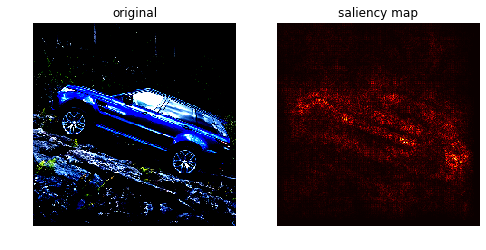

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


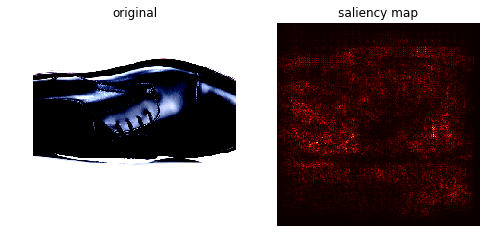

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


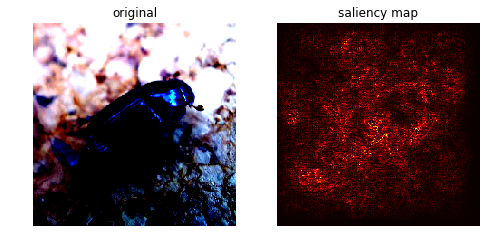

In [0]:
criterion = torch.nn.functional.cross_entropy
saliency = compute_saliency_map(images, labels, pytorch_model, criterion, device)
plot_saliency(images[err_instances], saliency[err_instances])

**Comment:** The noisy saliency maps of image 10 and 18 could explain their wrong predictions. But even though image 6 had reasonable saliency map, the model still predicted it wrongly. Note that image 6 and image 5 were of the same class and image 5 had correct predition. Comparing the saliency map of image 5 and image 6, one could find that although both of them had strong signals from the body of car, saliency map of image 6 also displayed strong signals from background (sky). This fact may indicate that the model consider sky as one evidence of SUV, which is not true in general.

#### Saliency map of all images

In [0]:
for i in range(len(images)):
    fig = plt.figure(figsize=(8, 4))
    ax = plt.subplot(121)
    ax.set_title('original')
    plt.imshow(convert2channel_last(images[i]))
    plt.axis('off')
    
    ax = plt.subplot(122)
    ax.set_title('saliency map')
    plt.imshow((saliency[i]), cmap=plt.cm.hot)
    plt.axis('off')
    plt.show()

Output hidden; open in https://colab.research.google.com to view.